Exercício - Sistema Fuzzy para escolha de arma do NPC

Disciplina de Inteligência Artificial I

Acadêmica: Helena Becker Piazera

Etapa 1: Importando bibliotecas

In [ ]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 16.0 MB/s eta 0:00:00


Etapa 2: Definindo as variáveis Fuzzy


*   Distância
*   Munição
*   Desejabilidade (Indesejável – Desejável – Imprescindível)



In [ ]:
# Entradas do sistema
distancia = ctrl.Antecedent(np.arange(0, 101, 1), 'distancia')  # 0 a 100 metros
municao = ctrl.Antecedent(np.arange(0, 11, 1), 'municao')      # 0 a 10 munições

# Saída do sistema
desejabilidade = ctrl.Consequent(np.arange(0, 11, 1), 'desejabilidade')

Etapa 3: Definindo as funções de pertinência

In [ ]:
# Distância
distancia['perto'] = fuzz.trimf(distancia.universe, [0, 0, 30])
distancia['medio'] = fuzz.trimf(distancia.universe, [20, 50, 80])
distancia['longe'] = fuzz.trimf(distancia.universe, [60, 100, 100])

# Munição
municao['baixa'] = fuzz.trimf(municao.universe, [0, 0, 3])
municao['media'] = fuzz.trimf(municao.universe, [2, 5, 8])
municao['alta'] = fuzz.trimf(municao.universe, [6, 10, 10])

# Desejabilidade
desejabilidade['indesejavel'] = fuzz.trimf(desejabilidade.universe, [0, 0, 4])
desejabilidade['desejavel'] = fuzz.trimf(desejabilidade.universe, [3, 5, 7])
desejabilidade['imprescindivel'] = fuzz.trimf(desejabilidade.universe, [6, 10, 10])

Etapa 4: Visualizando os conjuntos fuzzy

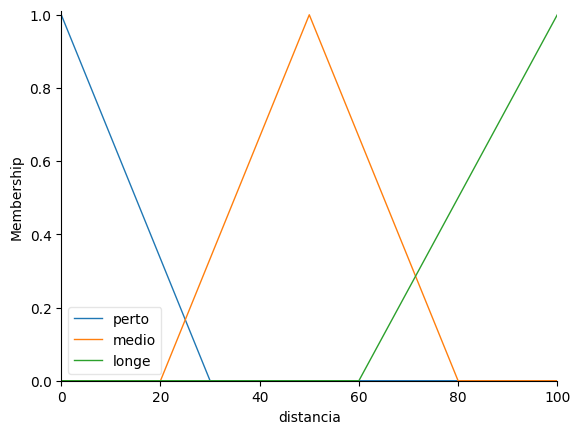

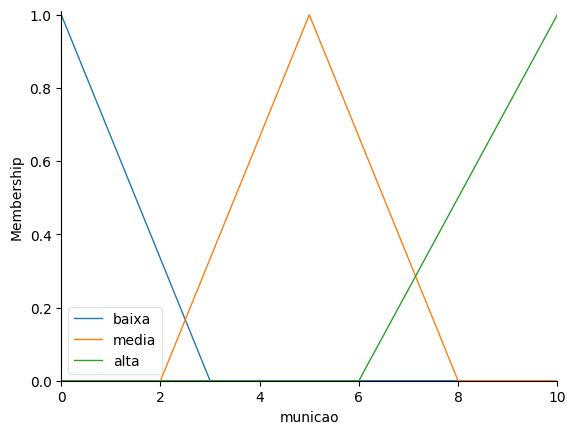

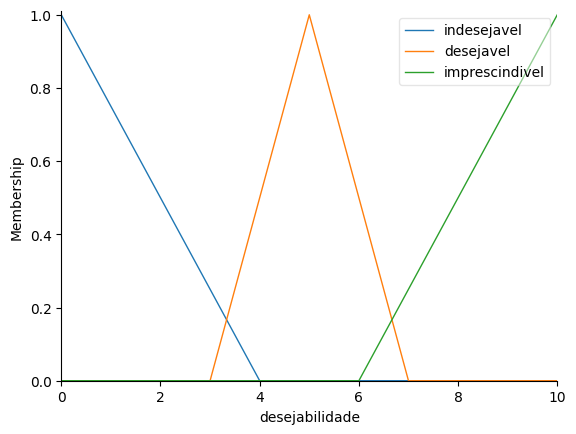

In [ ]:
distancia.view()
plt.show()
print("\n")

municao.view()
plt.show()
print("\n")

desejabilidade.view()
plt.show()
print("\n")

Etapa 5: Definindo regras fuzzy

Cada arma tem seu próprio conjunto de regras:

*   Foguete → bom de longe, ruim de perto.
*   Sniper → ótimo de médio/longo alcance, ruim de perto.
*   Pistola → melhor de perto, ruim de longe.









In [ ]:
# Regras para LANÇADOR DE FOGUETES
regra1 = ctrl.Rule(distancia['longe'] & (municao['media'] | municao['alta']), desejabilidade['imprescindivel'])
regra2 = ctrl.Rule(distancia['medio'] & municao['media'], desejabilidade['desejavel'])
regra3 = ctrl.Rule(distancia['perto'] | municao['baixa'], desejabilidade['indesejavel'])

forguete_ctrl = ctrl.ControlSystem([regra1, regra2, regra3])
foguete_simulador = ctrl.ControlSystemSimulation(forguete_ctrl)

# Regras para RIFLE SNIPER
regra4 = ctrl.Rule((distancia['medio'] | distancia['longe']) & (municao['media'] | municao['alta']), desejabilidade['imprescindivel'])
regra5 = ctrl.Rule(distancia['medio'] & municao['baixa'], desejabilidade['desejavel'])
regra6 = ctrl.Rule(distancia['perto'], desejabilidade['indesejavel'])

sniper_ctrl = ctrl.ControlSystem([regra4, regra5, regra6])
sniper_simulador = ctrl.ControlSystemSimulation(sniper_ctrl)

# Regras para PISTOLA
regra7 = ctrl.Rule(distancia['perto'] & (municao['media'] | municao['alta']), desejabilidade['imprescindivel'])
regra8 = ctrl.Rule(distancia['perto'] & municao['baixa'], desejabilidade['desejavel'])
regra9 = ctrl.Rule((distancia['medio'] | distancia['longe']), desejabilidade['indesejavel'])

pistola_ctrl = ctrl.ControlSystem([regra7, regra8, regra9])
pistola_simulador = ctrl.ControlSystemSimulation(pistola_ctrl)

Etapa 6: Função para escolher melhor arma a partir de uma distância e quantidade de munição

In [ ]:
def escolher_arma(dist, mun):
    # Simula foguete
    foguete_simulador.input['distancia'] = dist
    foguete_simulador.input['municao'] = mun
    foguete_simulador.compute()

    # Simula sniper
    sniper_simulador.input['distancia'] = dist
    sniper_simulador.input['municao'] = mun
    sniper_simulador.compute()

    # Simula pistola
    pistola_simulador.input['distancia'] = dist
    pistola_simulador.input['municao'] = mun
    pistola_simulador.compute()

    # Agrupa os resultados em dicionario
    resultados = {
        "Lançador de foguetes": foguete_simulador.output['desejabilidade'],
        "Rifle Sniper": sniper_simulador.output['desejabilidade'],
        "Pistola": pistola_simulador.output['desejabilidade']
    }

    #Define o melhor resultado com base no maior valor de resultado
    melhor = max(resultados, key=resultados.get)
    #Retorna a melhor escolha de arma e os resultados para cada arma
    return melhor, resultados

Etapa 7: Função para classificar linguisticamente o valor de saída

In [ ]:
mapa_de_rotulos = {
    'indesejavel': 'Indesejável',
    'desejavel': 'Desejável',
    'imprescindivel': 'Imprescindível'
}

def get_rotulo_linguistico(valor, variavel_consequente):
    graus_de_pertinencia = {
        termo: fuzz.interp_membership(variavel_consequente.universe, variavel_consequente[termo].mf, valor)
        for termo in variavel_consequente.terms
    }
    # Encontra o termo com o maior grau de pertinência
    melhor_termo = max(graus_de_pertinencia, key=graus_de_pertinencia.get)
    # Retorna o rótulo traduzido do dicionário
    return mapa_de_rotulos[melhor_termo]

Etapa 8: Testando o sistema Fuzzy


*   avaliando os resultados de desejabilidade para cada arma com base em distância e munição

*   apresenta todos os resultado da defuzzificação, a variável de saída (Indesejável – Desejável – Imprescindível) de cada arma e a melhor escolha




In [ ]:
casos_teste = [
    (10, 2),   # Muito perto e pouca munição
    (10, 7),   # Perto e bastante munição
    (55, 5),   # Distância média e munição média
    (75, 8),   # Longe e bastante munição
    (90, 9),   # Muito longe e munição alta
    (30, 1),   # Perto/médio e munição quase zero
    (86, 3)    # Longe e pouca munição
]

# Loop para executar e imprimir os resultados
for dist, mun in casos_teste:
    melhor_arma, resultados = escolher_arma(dist, mun)

    # Obtém os valores numéricos
    val_foguetes = resultados['Lançador de foguetes']
    val_sniper = resultados['Rifle Sniper']
    val_pistola = resultados['Pistola']

    # Obtém os rótulos linguísticos para cada resultado
    rotulo_foguetes = get_rotulo_linguistico(val_foguetes, desejabilidade)
    rotulo_sniper = get_rotulo_linguistico(val_sniper, desejabilidade)
    rotulo_pistola = get_rotulo_linguistico(val_pistola, desejabilidade)

    # Apresentando resultado de cada teste
    print(f"Distância = {dist}m e Munição = {mun}")
    print(f"  - Foguetes: {val_foguetes:.2f} ({rotulo_foguetes})")
    print(f"  - Sniper:  {val_sniper:.2f} ({rotulo_sniper})")
    print(f"  - Pistola: {val_pistola:.2f} ({rotulo_pistola})")
    print(f"  Melhor Escolha: {melhor_arma}")
    print("\n")

Distância = 10m e Munição = 2
  - Foguetes: 1.44 (Indesejável)
  - Sniper:  1.44 (Indesejável)
  - Pistola: 5.00 (Desejável)
  Melhor Escolha: Pistola


Distância = 10m e Munição = 7
  - Foguetes: 1.44 (Indesejável)
  - Sniper:  1.44 (Indesejável)
  - Pistola: 8.31 (Imprescindível)
  Melhor Escolha: Pistola


Distância = 55m e Munição = 5
  - Foguetes: 5.00 (Desejável)
  - Sniper:  8.63 (Imprescindível)
  - Pistola: 1.37 (Indesejável)
  Melhor Escolha: Rifle Sniper


Distância = 75m e Munição = 8
  - Foguetes: 8.35 (Imprescindível)
  - Sniper:  8.35 (Imprescindível)
  - Pistola: 1.65 (Indesejável)
  Melhor Escolha: Lançador de foguetes


Distância = 90m e Munição = 9
  - Foguetes: 8.60 (Imprescindível)
  - Sniper:  8.60 (Imprescindível)
  - Pistola: 1.40 (Indesejável)
  Melhor Escolha: Lançador de foguetes


Distância = 30m e Munição = 1
  - Foguetes: 1.44 (Indesejável)
  - Sniper:  5.00 (Desejável)
  - Pistola: 1.69 (Indesejável)
  Melhor Escolha: Rifle Sniper


Distância = 86m e Muni